# 20/03/2024
Resnet training for satellite images

In [15]:
%load_ext autoreload
%autoreload 2

import random

import geopandas as gpd
import numpy as np
import seaborn
import tensorflow as tf
from matplotlib import pyplot as plt

In [11]:
# set random seed / make reproducible
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
print('TensorFlow version: {}'.format(tf.__version__))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found - On for CPU time!')
else:
    print('Found GPU at {}'.format(device_name))

In [21]:
#load labels to images and observe it
labels = gpd.read_file('../outputs/matched/gauteng-qol-cluster-tiles.geojson')
labels = labels[["tile", "qol_index"]]
print(len(labels))
labels.head()

22150


,tile,qol_index
0,1178-866_14_00.tiff,52.795907
1,1178-866_14_01.tiff,52.795907
2,1178-866_14_02.tiff,52.795907
3,1178-866_14_03.tiff,52.795907
4,1178-866_15_00.tiff,52.795907


<Figure size 1000x600 with 0 Axes>

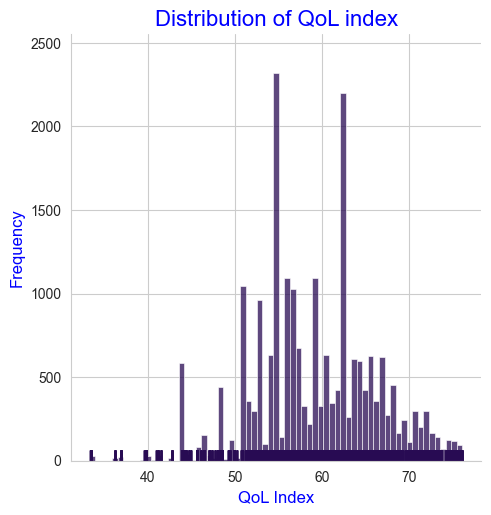

In [19]:
plt.figure(figsize=(10, 6))
seaborn.set_style('whitegrid')
seaborn.set_palette('inferno')
seaborn.displot(labels['qol_index'], rug=True, kde_kws={'fill':True, 'color':'r'})
plt.xlabel('QoL Index', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of QoL index', fontsize=16, color='b')
plt.show()

In [20]:
from keras.src.preprocessing.image import ImageDataGenerator

# create datagenerator object for training and validation datasets
#rescale images using 1/255
train_datagen = ImageDataGenerator(
            #we will do normalization for image pixel values as following
            rescale=1 / 255
            )

#use flow_from_dataframe method to load images from directory and labels from dataframe
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory='../outputs/tiles',
    x_col="tile", 
    y_col="qol_index",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="raw",
    #to convert all images to same pixel size, for neural networks, all images should have similar size
    target_size=(256,256),
    #we will load images batch by batch (every time 32 images will be loaded)
    batch_size=32,
    seed=42,
    )

Found 22150 validated image filenames.


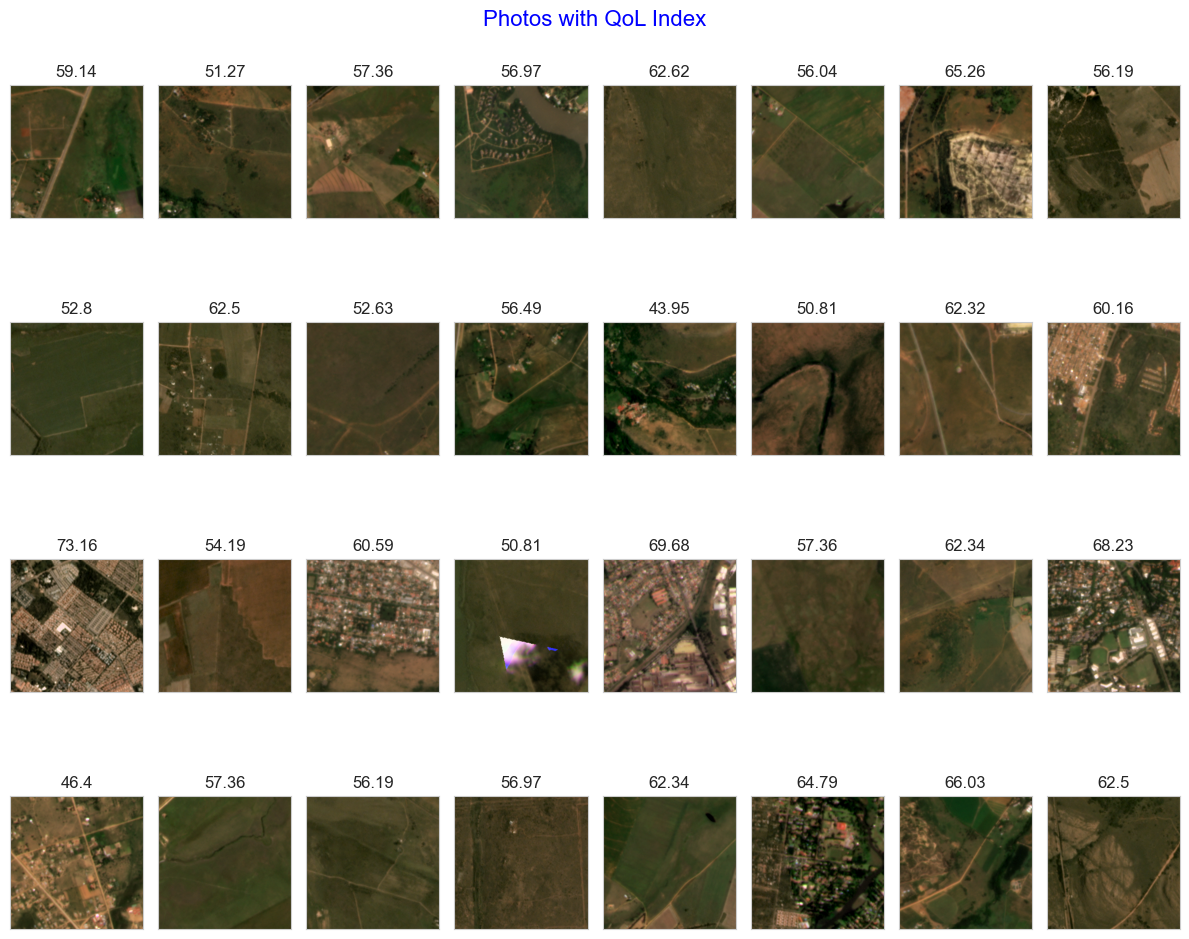

In [23]:
#get one batch from our datagenerator and display images in it
features, target = next(train_datagen_flow)

# display 16 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{round(target[i], 2)}')
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with QoL Index',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

In [26]:
from keras.src.optimizers import Adam
from keras.src.layers import Dropout, GlobalAveragePooling2D, Dense


def load_dataset(subset):
    
    """
    It loads the train part of dataset from path
    """
    
    all_labels = gpd.read_file('../outputs/matched/gauteng-qol-cluster-tiles.geojson')
    all_labels = all_labels[["tile", "qol_index"]]
    data = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    data_flow = data.flow_from_dataframe(
        dataframe=all_labels,
        directory="../outputs/tiles",
        x_col='tile',
        y_col='qol_index',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset = subset,
        seed=42)

    return data_flow



def create_model(input_shape):
    
    """
    It defines the model
    """
    # we will use ResNet50 architecture, with freezing top layers
    backbone = ResNet50V2(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    
    #now we will add our custom layers
    #without drop layer, neural networks can easily overfit
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    
    #final layer, since we are doing regression we will add only one neuron (unit)
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=0.0003)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    print(model.summary())

    return model


def train_model(model_param, train_data_param, test_data_param, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model_param.fit(train_data_param, validation_data=test_data_param, batch_size=batch_size, 
              epochs=epochs, steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, verbose=2)

    return model_param

In [27]:
#load training and testing (actually this is validation data set)
train_data = load_dataset("training")
test_data = load_dataset("validation")

#build a model
model = create_model(input_shape = (256, 256, 3))

Found 16613 validated image filenames.
Found 5537 validated image filenames.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 23521409 (89.73 MB)
Non-trainable params: 45440 (177.50 KB)
_______________________________________________________________

In [ ]:
# Need GPU for this step (trainable params are imagenet params)
model = train_model(model, train_data, test_data) 

In [3]:
from keras.src.applications import ResNet50V2
from tensorflow.keras import Sequential

my_new_model = Sequential()
my_new_model.add(ResNet50V2(include_top=False, pooling='avg', weights="imagenet"))

# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False

my_new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23564800 (89.89 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________
